# Lab Three for UW AMATH 563
## Assignment: Fashion MNIST Classification
## By Rebecca Lopez

For this lab, we will use the Fashion MNIST dataset to design a fully-connected network as well as dive into the optimizers, operations or modules that we have learned in the lectures, and to see how they can benefit the capacity of our model.

In [18]:
#Import Necessary Packages & Libraries
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn
import random
from tabulate import tabulate

In [19]:
#Define train batch size
train_batch_size = 100 
#Define test batch size 
test_batch_size  = 200 
#Define validation batch size
valid_batch_size = 200

# Use the following code to load and normalize the dataset
train_set = torchvision.datasets.FashionMNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))
train_set, val_set = torch.utils.data.random_split(train_set, [int(len(train_set)*0.8), int(len(train_set)*0.2)])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=train_batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_set, batch_size=test_batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.FashionMNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=test_batch_size, shuffle=True)

## Optimizers
Here we alternate various optimizers including RMSProp, Adam and SGD where we log oour training loss and test accuracy. 

In [ ]:
#Define your network:
class Network(nn.Module):
    def __init__(self,input_dim,hidden_dim1,hidden_dim2,output_dim): #Can provide additional inputs for initialization
    #Define the network layer(s) and activation function(s)
        super(Network, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim1)
        self.layer2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.layer3 = nn.Linear(hidden_dim2, output_dim)

    def forward(self, input):
        output = F.sigmoid(self.layer1(input))
        output = F.sigmoid(self.layer2(output))
        output = F.sigmoid(self.layer3(output))
        return output

#Define your hyperparameters
input_dim=784
hidden_dim1=100
hidden_dim2=100
output_dim=10
epochs = 15

model = Network(input_dim,hidden_dim1,hidden_dim2,output_dim)

#Define optimizers
optimizer1 = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer2 = torch.optim.SGD(model.parameters(), lr=0.001)
optimizer3 = torch.optim.SGD(model.parameters(), lr=0.001,momentum=0.2, weight_decay=0.1)
optimizer4 = torch.optim.Adadelta(model.parameters(), lr=0.001)
optimizer5 = torch.optim.RMSprop(model.parameters(), lr=0.001)

optimizers=[optimizer1,optimizer2,optimizer3,optimizer4,optimizer5]
opt_count=len(optimizers)

loss_fn   = nn.CrossEntropyLoss()
num_epoch=len(train_loader)

loss_list     = np.zeros((epochs*num_epoch,opt_count))
accuracy_list = np.zeros((epochs,opt_count))

#Train network
for opt_method in range(opt_count):
    optimizer=optimizers[opt_method]
    bt_num=0
    for epoch in range(epochs):
        for train_sample in train_loader:
            input=train_sample[0]
            input=input.reshape(train_batch_size,1,input_dim)
            targets=train_sample[1]
            
            #Calculate training loss on model
            output = model(input)
            loss = loss_fn(output.squeeze(), targets)
            loss_list[bt_num,opt_method] = loss.item()

            # Zero gradients
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            bt_num+=1


        #Validation
        with torch.no_grad():
            for valid_sample in valid_loader:
                valid_X,valid_Y = next(iter(valid_loader))
                input_valid=valid_X.reshape((valid_batch_size,input_dim))
                output_valid=model(input_valid)
                correct = (torch.argmax(torch.Tensor(output_valid), dim=1) == valid_Y).type(torch.FloatTensor)
                accuracy_list[epoch,opt_method] = correct.mean()
                

╒═══════════════════╤══════════════════╤══════════════╕
│ Method            │   Final Accuracy │   Final Loss │
╞═══════════════════╪══════════════════╪══════════════╡
│ Adam              │            0.805 │      1.56417 │
├───────────────────┼──────────────────┼──────────────┤
│ SGD               │            0.765 │      1.5387  │
├───────────────────┼──────────────────┼──────────────┤
│ SGD with Momentum │            0.79  │      1.68148 │
├───────────────────┼──────────────────┼──────────────┤
│ Adadelta          │            0.76  │      1.66908 │
├───────────────────┼──────────────────┼──────────────┤
│ RMSprop           │            0.895 │      1.51739 │
╘═══════════════════╧══════════════════╧══════════════╛


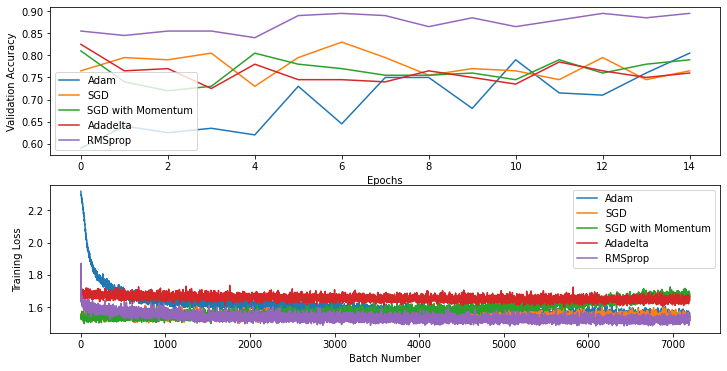

In [20]:
#Produce plot comparing the validation accuracy and training loss for various optimizers             
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=False)

ax1.plot(accuracy_list)
ax1.set_ylabel("Validation Accuracy")
ax1.legend(['Adam','SGD','SGD with Momentum','Adadelta','RMSprop'])
ax1.set_xlabel("Epochs");
ax2.plot(loss_list)
ax2.legend(['Adam','SGD','SGD with Momentum','Adadelta','RMSprop'])
ax2.set_ylabel("Training Loss")
ax2.set_xlabel("Batch Number");
table = [['Method', 'Final Accuracy', 'Final Loss'], ['Adam', accuracy_list[-1,0],loss_list[-1,0] ], ['SGD', accuracy_list[-1,1],loss_list[-1,1]], ['SGD with Momentum',accuracy_list[-1,2],loss_list[-1,2]],['Adadelta',accuracy_list[-1,3],loss_list[-1,3]],['RMSprop',accuracy_list[-1,4],loss_list[-1,4]]]
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))
#Define your network:

## Regularization
We use regularization like L2/L1, Dropout layers, etc. to improve your performance where we analyze the balance between regularization and the loss optimization.

In [ ]:
#Define your network:
class Network(nn.Module):
    def __init__(self,input_dim,hidden_dim1,hidden_dim2,output_dim,reg_method): #Can provide additional inputs for initialization
    #Define the network layer(s) and activation function(s)
        super(Network, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim1)
        self.layer2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.layer3 = nn.Linear(hidden_dim2, output_dim)
        
        if reg_method==1:
            self.dropout=nn.Dropout(0.24)
            

    def forward(self, input):
    #How does your model process the input?
        output = F.sigmoid(self.layer1(input))
        output = F.sigmoid(self.layer2(output))
        output = F.sigmoid(self.layer3(output))
        return output

#Various methods of Regularization    
reg_names=['Default','DropOut','L2 Regulazation']
reg_count=len(reg_names)

#Define hyperparameters
input_dim=784
hidden_dim1=100
hidden_dim2=100
output_dim=10
num_epoch=len(train_loader)

loss_list     = np.zeros((epochs*num_epoch,reg_count))
accuracy_list = np.zeros((epochs,reg_count))

#Train network
for reg_method in range(reg_count):
    model = Network(input_dim,hidden_dim1,hidden_dim2,output_dim, reg_method)
    
    if reg_method==2:
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
    else:
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    epochs = 15
    loss_fn   = nn.CrossEntropyLoss()

    bt_num=0
    for epoch in range(epochs):
        for train_sample in train_loader:
            input=train_sample[0]
            input=input.reshape(train_batch_size,1,input_dim)
            targets=train_sample[1]
            
            #Calculate training loss on model
            output = model(input)
            loss = loss_fn(output.squeeze(), targets)
            loss_list[bt_num,reg_method] = loss.item()

            # Zero gradients
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            bt_num+=1


        #Validation
        with torch.no_grad():
            for valid_sample in valid_loader:
                valid_X,valid_Y = next(iter(valid_loader))
                input_valid=valid_X.reshape((valid_batch_size,input_dim))
                output_valid=model(input_valid)
                correct = (torch.argmax(torch.Tensor(output_valid), dim=1) == valid_Y).type(torch.FloatTensor)
                accuracy_list[epoch,reg_method] = correct.mean()
                

c:\users\rebec\appdata\local\programs\python\python38\lib\site-packages\torch\nn\functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


╒═════════════════╤══════════════════╤══════════════╕
│ Method          │   Final Accuracy │   Final Loss │
╞═════════════════╪══════════════════╪══════════════╡
│ Default         │            0.545 │      1.56847 │
├─────────────────┼──────────────────┼──────────────┤
│ DropOut         │            0.815 │      1.55642 │
├─────────────────┼──────────────────┼──────────────┤
│ L2 Regulazation │            0.425 │      1.69179 │
╘═════════════════╧══════════════════╧══════════════╛


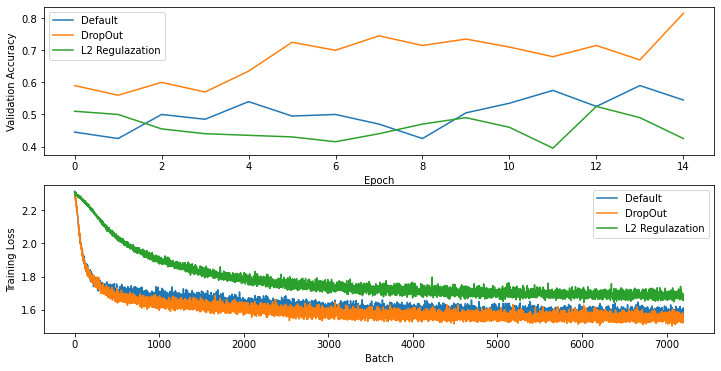

In [21]:
#Produce plot comparing the validation accuracy and training loss for various regularization methods
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=False)

ax1.plot(accuracy_list)
ax1.set_ylabel("Validation Accuracy")
ax1.set_xlabel("Epoch");
ax1.legend(reg_names)
ax2.plot(loss_list)
ax2.legend(reg_names)
ax2.set_ylabel("Training Loss")
ax2.set_xlabel("Batch");
table = [['Method', 'Final Accuracy', 'Final Loss'], [reg_names[0], accuracy_list[-1,0],loss_list[-1,0] ], [reg_names[1], accuracy_list[-1,1],loss_list[-1,1]], [reg_names[2],accuracy_list[-1,2],loss_list[-1,2]]]
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))


## Initialization 
We use various intialization methods like random normal, Xavier and He (Kaiming) etc and analyze how these methods affect our training process and performance.

In [ ]:
#Define your network:
class Network(nn.Module):
    def __init__(self,input_dim,hidden_dim1,hidden_dim2,output_dim,init_method): #Can provide additional inputs for initialization
    #Define the network layer(s) and activation function(s)
        super(Network, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim1)
        self.layer2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.layer3 = nn.Linear(hidden_dim2, output_dim)
        
        if init_method==1:
            torch.nn.init.xavier_normal_(self.layer1.weight)
            torch.nn.init.xavier_normal_(self.layer2.weight)
            torch.nn.init.xavier_normal_(self.layer3.weight)
        elif init_method==2:
            torch.nn.init.kaiming_normal_(self.layer1.weight)
            torch.nn.init.kaiming_normal_(self.layer2.weight)
            torch.nn.init.kaiming_normal_(self.layer3.weight)
        elif init_method==3:
            torch.nn.init.normal_(self.layer1.weight)
            torch.nn.init.normal_(self.layer2.weight)
            torch.nn.init.normal_(self.layer3.weight)
        

    def forward(self, input):
        output = F.sigmoid(self.layer1(input))
        output = F.sigmoid(self.layer2(output))
        output = F.sigmoid(self.layer3(output))
        return output

#Various Initialization Methods
init_names=['Default','Xavier','Kaming','Normal']
init_count=len(init_names)

#Define hyperparameters
input_dim=784
hidden_dim1=100
hidden_dim2=100
output_dim=10
num_epoch=len(train_loader)

loss_list     = np.zeros((epochs*num_epoch,init_count))
accuracy_list = np.zeros((epochs,init_count))

#Train Network
for init_method in range(init_count):
    model = Network(input_dim,hidden_dim1,hidden_dim2,output_dim, init_method)
    
    #Define optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    #Define additional hyperparameters
    int_count=4
    epochs = 15
    
    #Define loss function
    loss_fn   = nn.CrossEntropyLoss()

    bt_num=0
    for epoch in range(epochs):
        for train_sample in train_loader:
            input=train_sample[0]
            input=input.reshape(train_batch_size,1,input_dim)
            targets=train_sample[1]
            
            #Calculate training loss on model
            output = model(input)
            loss = loss_fn(output.squeeze(), targets)
            loss_list[bt_num,init_method] = loss.item()

            # Zero gradients
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            bt_num+=1


        #Validation
        with torch.no_grad():
            for valid_sample in valid_loader:
                valid_X,valid_Y = next(iter(valid_loader))
                input_valid=valid_X.reshape((valid_batch_size,input_dim))
                output_valid=model(input_valid)
                correct = (torch.argmax(torch.Tensor(output_valid), dim=1) == valid_Y).type(torch.FloatTensor)
                accuracy_list[epoch,init_method] = correct.mean()
                

c:\users\rebec\appdata\local\programs\python\python38\lib\site-packages\torch\nn\functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


╒══════════╤══════════════════╤══════════════╕
│ Method   │   Final Accuracy │   Final Loss │
╞══════════╪══════════════════╪══════════════╡
│ Default  │            0.58  │      1.60565 │
├──────────┼──────────────────┼──────────────┤
│ Xavier   │            0.875 │      1.53331 │
├──────────┼──────────────────┼──────────────┤
│ Kaming   │            0.92  │      1.54067 │
├──────────┼──────────────────┼──────────────┤
│ Normal   │            0.82  │      1.5793  │
╘══════════╧══════════════════╧══════════════╛


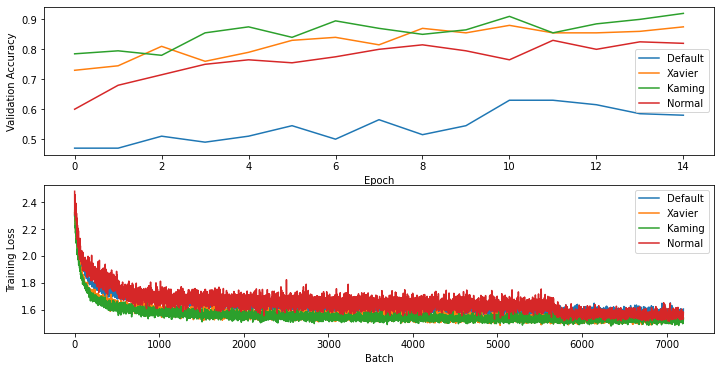

In [22]:
#Produce plot comparing the validation accuracy and training loss for various intialization methods
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=False)

ax1.plot(accuracy_list)
ax1.set_ylabel("Validation Accuracy")
ax1.set_xlabel("Epoch");
ax1.legend(init_names)
ax2.plot(loss_list)
ax2.legend(init_names)
ax2.set_ylabel("Training Loss")
ax2.set_xlabel("Batch");
table = [['Method', 'Final Accuracy', 'Final Loss'], [init_names[0], accuracy_list[-1,0],loss_list[-1,0] ], [init_names[1], accuracy_list[-1,1],loss_list[-1,1]], [init_names[2],accuracy_list[-1,2],loss_list[-1,2]],[init_names[3],accuracy_list[-1,3],loss_list[-1,3]]]
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))


## Normalization 
We use various normalization like batch normalization or layer normalization and analyze whether these normalization methods can help  training or performance.

In [ ]:
#Define your network:
class Network(nn.Module):
    def __init__(self,input_dim,hidden_dim1,hidden_dim2,output_dim,norm_choice): #Can provide additional inputs for initialization
    #Define the network layer(s) and activation function(s)
        super(Network, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim1)
        if norm_choice ==1:
            self.layer1_bn = nn.BatchNorm2d(hidden_dim1)
        if norm_choice ==2:
            self.layer1_ln = nn.LayerNorm(hidden_dim1)
            
        self.layer2 = nn.Linear(hidden_dim1, hidden_dim2)
        if norm_choice ==1:
            self.layer2_bn = nn.BatchNorm2d(hidden_dim2)
        if norm_choice ==2:
            self.layer2_ln = nn.LayerNorm(hidden_dim2)
            
        self.layer3 = nn.Linear(hidden_dim2, output_dim)
        if norm_choice ==1:
            self.layer3_bn = nn.BatchNorm2d(output_dim)
        if norm_choice ==2:
            self.layer3_ln = nn.LayerNorm(output_dim)
    

    def forward(self, input):
        output = F.sigmoid(self.layer1(input))
        output = F.sigmoid(self.layer2(output))
        output = F.sigmoid(self.layer3(output))
        return output

#Define normalization techniques
norm_names=['Default','Batch','Layer']
norm_count=len(init_names)

#Define hyperparameters
input_dim=784
hidden_dim1=100
hidden_dim2=100
output_dim=10
num_epoch=len(train_loader)

loss_list     = np.zeros((epochs*num_epoch,int_count))
accuracy_list = np.zeros((epochs,int_count))

# Train Network
for norm_choice in range(norm_count):
    model = Network(input_dim,hidden_dim1,hidden_dim2,output_dim, norm_choice)

    #Define optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    epochs = 15
    
    #Define loss function
    loss_fn   = nn.CrossEntropyLoss()

    bt_num=0
    for epoch in range(epochs):
        for train_sample in train_loader:
            input=train_sample[0]
            input=input.reshape(train_batch_size,1,input_dim)
            targets=train_sample[1]
            
            #Calculate training loss on model
            output = model(input)
            loss = loss_fn(output.squeeze(), targets)
            loss_list[bt_num,norm_choice] = loss.item()

            # Zero gradients
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            bt_num+=1


        #Validation
        with torch.no_grad():
            for valid_sample in valid_loader:
                valid_X,valid_Y = next(iter(valid_loader))
                input_valid=valid_X.reshape((valid_batch_size,input_dim))
                output_valid=model(input_valid)
                correct = (torch.argmax(torch.Tensor(output_valid), dim=1) == valid_Y).type(torch.FloatTensor)
                accuracy_list[epoch,norm_choice] = correct.mean()
                

c:\users\rebec\appdata\local\programs\python\python38\lib\site-packages\torch\nn\functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


╒══════════╤══════════════════╤══════════════╕
│ Method   │   Final Accuracy │   Final Loss │
╞══════════╪══════════════════╪══════════════╡
│ Default  │            0.905 │      1.54454 │
├──────────┼──────────────────┼──────────────┤
│ Batch    │            0.82  │      1.56579 │
├──────────┼──────────────────┼──────────────┤
│ Layer    │            0.76  │      1.52764 │
╘══════════╧══════════════════╧══════════════╛


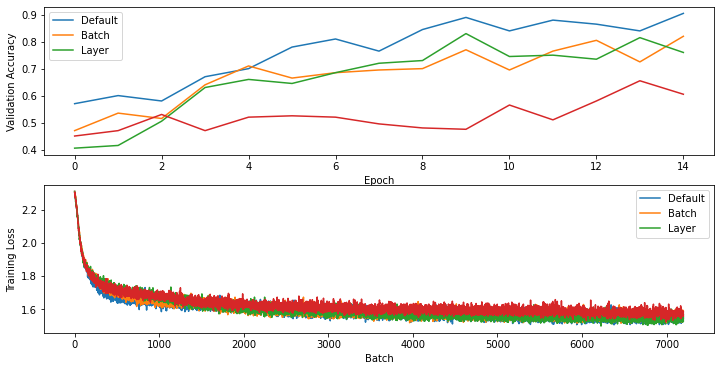

In [23]:
#Produce plot comparing the validation accuracy and training loss for various normalization methods
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=False)

ax1.plot(accuracy_list)
ax1.set_ylabel("Validation Accuracy")
ax1.set_xlabel("Epoch");
ax1.legend(norm_names)
ax2.plot(loss_list)
ax2.legend(norm_names)
ax2.set_ylabel("Training Loss")
ax2.set_xlabel("Batch");
table = [['Method', 'Final Accuracy', 'Final Loss'], [norm_names[0], accuracy_list[-1,0],loss_list[-1,0] ], [norm_names[1], accuracy_list[-1,1],loss_list[-1,1]], [norm_names[2],accuracy_list[-1,2],loss_list[-1,2]]]
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

## Additional Hyperparameters


### Number of neurons in each layer
We set various neuron counts to try to analyze validation accuracy and training loss.

In [ ]:
#Define your network:
class Network(nn.Module):
    def __init__(self,input_dim,hidden_dim1,hidden_dim2,output_dim): #Can provide additional inputs for initialization
    #Define the network layer(s) and activation function(s)
        super(Network, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim1)
        self.layer2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.layer3 = nn.Linear(hidden_dim2, output_dim)

    def forward(self, input):
    #How does your model process the input?
        output = F.sigmoid(self.layer1(input))
        output = F.sigmoid(self.layer2(output))
        output = F.sigmoid(self.layer3(output))
        return output
    
#Setting various neuron values
param_vals=[10,50,100]   
param_names=['10','50','100']
param_count=len(param_names)

#Define your hyperparameters
input_dim=784
output_dim=10
num_epoch=len(train_loader)

loss_list     = np.zeros((epochs*num_epoch,param_count))
accuracy_list = np.zeros((epochs,param_count))

#Train network
for param_choice in range(param_count):
    hidden_dim1=param_vals[param_choice]
    hidden_dim2=param_vals[param_choice]
    model = Network(input_dim,hidden_dim1,hidden_dim2,output_dim)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    epochs = 15
    loss_fn   = nn.CrossEntropyLoss()

    bt_num=0
    for epoch in range(epochs):
        for train_sample in train_loader:
            input=train_sample[0]
            input=input.reshape(train_batch_size,1,input_dim)
            targets=train_sample[1]
            
            #Calculate training loss on model
            output = model(input)
            loss = loss_fn(output.squeeze(), targets)
            loss_list[bt_num,param_choice] = loss.item()

            # Zero gradients
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            bt_num+=1


        #Validation
        with torch.no_grad():
            for valid_sample in valid_loader:
                valid_X,valid_Y = next(iter(valid_loader))
                input_valid=valid_X.reshape((valid_batch_size,input_dim))
                output_valid=model(input_valid)
                correct = (torch.argmax(torch.Tensor(output_valid), dim=1) == valid_Y).type(torch.FloatTensor)
                accuracy_list[epoch,param_choice] = correct.mean()
                

In [24]:
#Produce table comparing the validation accuracy and training loss for various neuron counts
table = [['Neuron Count', 'Final Accuracy', 'Final Loss'], [param_names[0], accuracy_list[-1,0],loss_list[-1,0] ], [param_names[1], accuracy_list[-1,1],loss_list[-1,1]], [param_names[2],accuracy_list[-1,2],loss_list[-1,2]]]
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

c:\users\rebec\appdata\local\programs\python\python38\lib\site-packages\torch\nn\functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


╒════════════════╤══════════════════╤══════════════╕
│   Neuron Count │   Final Accuracy │   Final Loss │
╞════════════════╪══════════════════╪══════════════╡
│             10 │            0.49  │      1.64888 │
├────────────────┼──────────────────┼──────────────┤
│             50 │            0.485 │      1.61561 │
├────────────────┼──────────────────┼──────────────┤
│            100 │            0.655 │      1.58829 │
╘════════════════╧══════════════════╧══════════════╛


### Learning rate

In [ ]:
#Define your network:
class Network(nn.Module):
    def __init__(self,input_dim,hidden_dim1,hidden_dim2,output_dim): #Can provide additional inputs for initialization
    #Define the network layer(s) and activation function(s)
        super(Network, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim1)
        self.layer2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.layer3 = nn.Linear(hidden_dim2, output_dim)

    def forward(self, input):
    #How does your model process the input?
        output = F.sigmoid(self.layer1(input))
        output = F.sigmoid(self.layer2(output))
        output = F.sigmoid(self.layer3(output))
        return output
    
#Setting various learning rates
param_vals=[0.01,0.001,0.0001]   
param_names=['0.01','0.001','0.0001']
param_count=len(param_names)

#Define your hyperparameters
input_dim=784
hidden_dim1=100
hidden_dim2=100
output_dim=10
num_epoch=len(train_loader)

loss_list     = np.zeros((epochs*num_epoch,param_count))
accuracy_list = np.zeros((epochs,param_count))

#Train network
for param_choice in range(param_count):
    model = Network(input_dim,hidden_dim1,hidden_dim2,output_dim)

    optimizer = torch.optim.Adam(model.parameters(), lr=param_vals[param_choice])

    epochs = 15
    loss_fn   = nn.CrossEntropyLoss()

    bt_num=0
    for epoch in range(epochs):
        for train_sample in train_loader:
            input=train_sample[0]
            input=input.reshape(train_batch_size,1,input_dim)
            targets=train_sample[1]
            
            #Calculate training loss on model
            output = model(input)
            loss = loss_fn(output.squeeze(), targets)
            loss_list[bt_num,param_choice] = loss.item()

            # Zero gradients
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            bt_num+=1


        #Validation
        with torch.no_grad():
            for valid_sample in valid_loader:
                valid_X,valid_Y = next(iter(valid_loader))
                input_valid=valid_X.reshape((valid_batch_size,input_dim))
                output_valid=model(input_valid)
                correct = (torch.argmax(torch.Tensor(output_valid), dim=1) == valid_Y).type(torch.FloatTensor)
                accuracy_list[epoch,param_choice] = correct.mean()
                

In [25]:
#Produce table comparing the final validation accuracy and training loss for various learning rates
table = [['Learning Rate', 'Final Accuracy', 'Final Loss'], [param_names[0], accuracy_list[-1,0],loss_list[-1,0] ], [param_names[1], accuracy_list[-1,1],loss_list[-1,1]], [param_names[2],accuracy_list[-1,2],loss_list[-1,2]]]
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒═════════════════╤══════════════════╤══════════════╕
│   Learning Rate │   Final Accuracy │   Final Loss │
╞═════════════════╪══════════════════╪══════════════╡
│          0.01   │            0.79  │      1.58781 │
├─────────────────┼──────────────────┼──────────────┤
│          0.001  │            0.745 │      1.54263 │
├─────────────────┼──────────────────┼──────────────┤
│          0.0001 │            0.515 │      1.68075 │
╘═════════════════╧══════════════════╧══════════════╛


### Number of Epochs

In [31]:
#Define your network:
class Network(nn.Module):
    def __init__(self,input_dim,hidden_dim1,hidden_dim2,output_dim): #Can provide additional inputs for initialization
    #Define the network layer(s) and activation function(s)
        super(Network, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim1)
        self.layer2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.layer3 = nn.Linear(hidden_dim2, output_dim)

    def forward(self, input):
    #How does your model process the input?
        output = F.sigmoid(self.layer1(input))
        output = F.sigmoid(self.layer2(output))
        output = F.sigmoid(self.layer3(output))
        return output
    
#Setting various Epoch Count
param_vals=[10,15,20]   
param_names=['10 ','15','20']
param_count=len(param_names)
#Define your optimizer
input_dim=784
hidden_dim1=100
hidden_dim2=100
output_dim=10
num_epoch=len(train_loader)

epoch_comp_acc=[]
epoch_comp_loss=[]

for param_choice in range(param_count):
    model = Network(input_dim,hidden_dim1,hidden_dim2,output_dim)

    optimizer = torch.optim.Adam(model.parameters(), lr=param_vals[param_choice])

    epochs = param_vals[param_choice]
    loss_fn   = nn.CrossEntropyLoss()
    loss_list     = np.zeros((epochs*num_epoch,))
    accuracy_list = np.zeros((epochs,))

    bt_num=0
    for epoch in range(epochs):
        for train_sample in train_loader:
            input=train_sample[0]
            input=input.reshape(train_batch_size,1,input_dim)
            targets=train_sample[1]
            
            #Calculate training loss on model
            output = model(input)
            loss = loss_fn(output.squeeze(), targets)
            loss_list[bt_num] = loss.item()

            # Zero gradients
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            bt_num+=1


        #Validation
        with torch.no_grad():
            for valid_sample in valid_loader:
                valid_X,valid_Y = next(iter(valid_loader))
                input_valid=valid_X.reshape((valid_batch_size,input_dim))
                output_valid=model(input_valid)
                correct = (torch.argmax(torch.Tensor(output_valid), dim=1) == valid_Y).type(torch.FloatTensor)
                accuracy_list[epoch] = correct.mean()
    epoch_comp_acc.append(accuracy_list[-1])
    epoch_comp_loss.append(loss_list[-1])
 

[0.11999999731779099]
[0.11999999731779099, 0.10999999940395355]
[0.11999999731779099, 0.10999999940395355, 0.15000000596046448]


In [32]:
#Produce table comparing the final validation accuracy and training loss for various Epoch Counts
table = [['Epoch Count', 'Final Accuracy', 'Final Loss'], [param_names[0], epoch_comp_acc[0],epoch_comp_loss[0] ], [param_names[1], epoch_comp_acc[1],epoch_comp_loss[1]], [param_names[2],epoch_comp_acc[2],epoch_comp_loss[2]]]
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒═══════════════╤══════════════════╤══════════════╕
│   Epoch Count │   Final Accuracy │   Final Loss │
╞═══════════════╪══════════════════╪══════════════╡
│           10  │             0.12 │      2.4827  │
├───────────────┼──────────────────┼──────────────┤
│            15 │             0.11 │      2.50572 │
├───────────────┼──────────────────┼──────────────┤
│            20 │             0.15 │      2.3627  │
╘═══════════════╧══════════════════╧══════════════╛


For the comparing of different optimizers, regularization, initialization, normalization and hyper-parameters, you are recommended to form a table of the comparison results.  Report your loss as ”loss curve” and accuracy for different settings and draw conclusions. **You can split a small validation set from the training set to help you analyze the effectiveness of different modules better.**

For the convenient implementation of different optimizers, regularization, initialization and normalization, you can always check the tutorial of pytorch library (https://pytorch.org/tutorials/) for some useful funuctions and examples.